# Predicting on the holdout data
___

In [1]:
# import the libraries necessarry for cleaning and eda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='white')
plt.style.use('seaborn')

pd.set_option('display.max_columns', 100)  # display max rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # avoid outputing scientific notation

In [2]:
# read in the data
holdout = pd.read_csv("cardiac_test.csv")
print(holdout.shape)
holdout.head()

(12717, 13)


,age,gender,height,weight,bp_high,bp_low,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,62.312,female,1.540,70.000,130.000,60.000,above normal,normal,0,0,1,1,29.516
1,49.918,female,1.760,92.000,160.000,100.000,well above normal,above normal,0,0,1,0,29.700
2,55.564,male,1.680,69.000,140.000,90.000,above normal,normal,0,0,0,1,24.447
3,41.836,female,1.650,73.000,110.000,70.000,normal,normal,0,0,1,0,26.814
4,54.548,female,1.540,71.000,140.000,90.000,above normal,above normal,0,0,0,1,29.938


## Transforming the holdout
* We need to transform the train set the same way we did with the train set.

In [3]:
holdout['bmi_cat'] = pd.cut(holdout['bmi'], right= False, bins = [0,18.5,25,30,36], 
                       labels=['underweight','normal','overweight','obese'])
holdout['bmi_cat'].value_counts(dropna = False)

normal         5121
overweight     5000
obese          2460
underweight     136
Name: bmi_cat, dtype: int64

In [4]:
# create dummy columns from these categorical feature and assign it to a new data frame
dummy_holdout = pd.get_dummies(holdout, columns=['bmi_cat','gender'], prefix = '', prefix_sep = '', drop_first= True)

In [5]:
# we have more categorical columns that need to be converted into dummies
dummy_holdout = pd.get_dummies(dummy_holdout, columns=['cholesterol','gluc'], prefix =['chol','gluc'],)

In [6]:
dummy_holdout['bp_lvl'] = dummy_holdout['bp_high'].apply(lambda x: 'crisis' if (x >= 180) else
                                              ('hyper_2' if (x < 180) & (x >= 140) else
                                              ('hyper_1' if (x < 140) & (x >= 130) else
                                              ('normal' if (x < 130) & (x >= 90) else 'lowest'))))

In [7]:
dummy_holdout = pd.get_dummies(dummy_holdout, columns=['bp_lvl'], prefix =['bp'],) # make dummies for the new column

In [8]:
# rename columns to remove blank spaces
rename_cols = {'chol_above normal':'chol_above_normal', 'chol_well above normal':'chol_well_above_normal',
              'gluc_above normal':'gluc_above_normal', 'gluc_well above normal':'gluc_well_above_normal'}
dummy_holdout.rename(rename_cols, axis= 1, inplace= True)

### Normalize the data

In [9]:
# normalized = value - mean / standard deviation
norm_holdout = (dummy_holdout - dummy_holdout.mean())/ dummy_holdout.std()
norm_holdout['cardio'] = dummy_holdout['cardio']  # plug back in the original values for the target

In [10]:
norm_holdout.head()

,age,height,weight,bp_high,bp_low,smoke,alco,active,cardio,bmi,normal,overweight,obese,male,chol_above_normal,chol_normal,chol_well_above_normal,gluc_above_normal,gluc_normal,gluc_well_above_normal,bp_crisis,bp_hyper_1,bp_hyper_2,bp_lowest,bp_normal
0,1.349,-1.402,-0.148,0.237,-2.244,-0.322,-0.241,0.488,1,0.838,-0.821,1.242,-0.490,-0.768,2.612,-1.813,-0.343,-0.274,0.409,-0.281,-0.113,2.594,-0.563,-0.031,-1.269
1,-0.479,1.425,1.766,2.069,2.010,-0.322,-0.241,0.488,0,0.887,-0.821,1.242,-0.490,-0.768,-0.383,-1.813,2.914,3.652,-2.447,-0.281,-0.113,-0.385,1.778,-0.031,-1.269
2,0.354,0.397,-0.235,0.848,0.946,-0.322,-0.241,-2.051,1,-0.506,1.218,-0.805,-0.490,1.302,2.612,-1.813,-0.343,-0.274,0.409,-0.281,-0.113,-0.385,1.778,-0.031,-1.269
3,-1.670,0.012,0.113,-0.984,-1.181,-0.322,-0.241,0.488,0,0.122,-0.821,1.242,-0.490,-0.768,-0.383,0.551,-0.343,-0.274,0.409,-0.281,-0.113,-0.385,-0.563,-0.031,0.788
4,0.204,-1.402,-0.061,0.848,0.946,-0.322,-0.241,-2.051,1,0.950,-0.821,1.242,-0.490,-0.768,2.612,-1.813,-0.343,3.652,-2.447,-0.281,-0.113,-0.385,1.778,-0.031,-1.269


In [11]:
# Split data to be used in the models
features_holdout = norm_holdout.drop(columns=['cardio','height','smoke','alco','bp_low','male',
                                              'bp_lowest','bp_hyper_1','bp_high','weight'], axis = 1) # creating a matrix of features

target = norm_holdout['cardio'] # target is the column we're trying to predict 

In [12]:
features_holdout.shape # this should have the same number of columns as the train set had before modelling = 24

(12717, 15)

## Predict the target 
___

In [13]:
import pickle 

pickle_in = open('DecisionTree.pickle','rb')
final_model = pickle.load(pickle_in)

In [14]:
final_model.feature_importances_

array([0.12506165, 0.        , 0.00085584, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08520231, 0.        ,
       0.00107098, 0.00821434, 0.01531254, 0.08250721, 0.68177513])

In [15]:
predictions = final_model.predict(features_holdout)

In [16]:
predictions.size

12717

In [17]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

THRESHOLD = 0.5
predictions = np.where(final_model.predict_proba(features_holdout)[:,1] > THRESHOLD, 1, 0)

print("Test Recall: ", recall_score(target, predictions), '\n')
print("Test Accuracy: ", accuracy_score(target, predictions), '\n')
print('Test Precision: ', precision_score(target, predictions))

Test Recall:  0.6993237671119907 

Test Accuracy:  0.7283164268302272 

Test Precision:  0.7220708446866485


___

In [18]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)  # avoid outputing scientific notation
feat_imp = pd.DataFrame(data=final_model.feature_importances_, index=features_holdout.columns,
                         columns= ['importance'])

In [19]:
feat_imp = feat_imp[feat_imp['importance'] > 0]

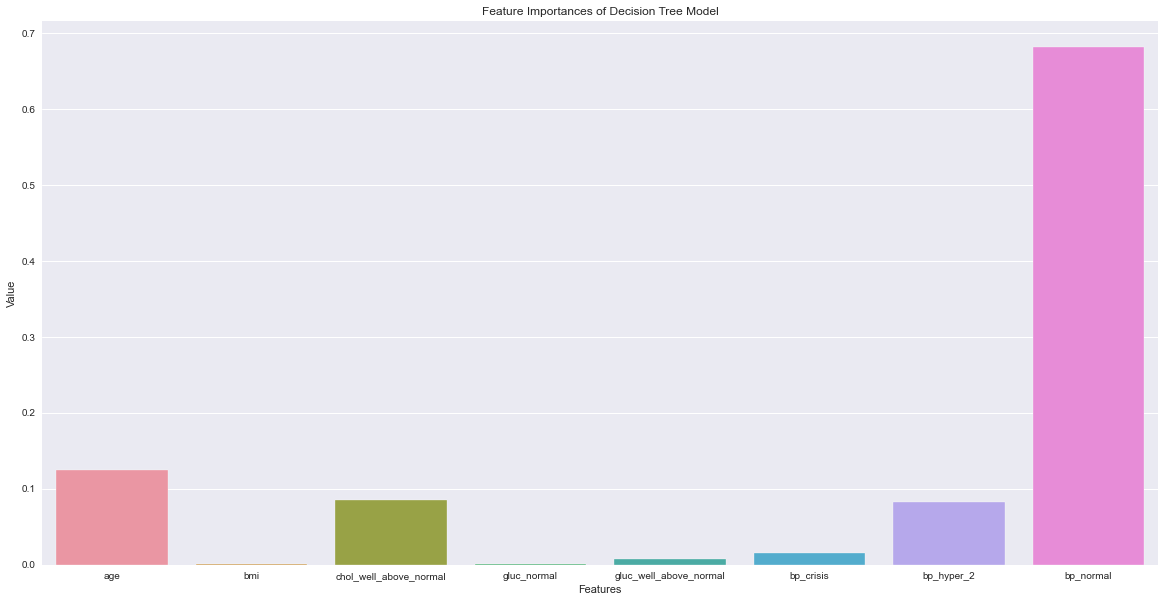

In [20]:
plt.figure(figsize= (20,10))
sns.barplot(x = feat_imp.index, y = feat_imp['importance'],)
plt.ylabel('Value')
plt.xlabel('Features')
plt.title('Feature Importances of Decision Tree Model')
plt.savefig('feature_imp_dct.png')

___

In [21]:
dummy_holdout['age_cat'] = pd.cut(dummy_holdout['age'], right= False, bins = [0,40,60,70], 
                       labels=['under-40','between_40-60','over-60'])
dummy_holdout['age_cat'].value_counts(dropna = False)

between_40-60    10058
over-60           2305
under-40           354
Name: age_cat, dtype: int64

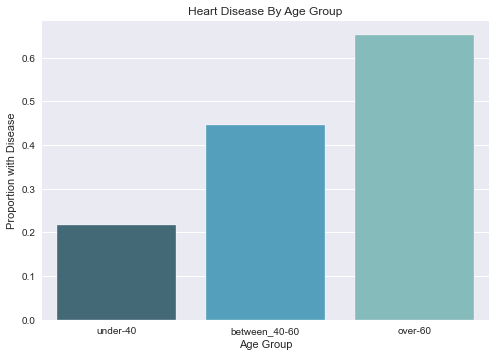

In [22]:
age_cat_mean = dummy_holdout.groupby('age_cat')['cardio'].mean()

sns.barplot(y= age_cat_mean, x= age_cat_mean.index, palette= 'GnBu_d' , )
plt.title('Heart Disease By Age Group')
plt.ylabel('Proportion with Disease')
plt.xlabel('Age Group')
plt.savefig('disease_by_age.png')

In [23]:
hyper_bp = dummy_holdout.groupby('bp_hyper_2')['cardio'].value_counts(normalize=True, )[1]
normal_bp = dummy_holdout.groupby('bp_normal')['cardio'].value_counts(normalize=True)[1]
obese = dummy_holdout.groupby('obese')['cardio'].value_counts(normalize=True)[1]
high_chol = dummy_holdout.groupby('chol_well_above_normal')['cardio'].value_counts(normalize=True)[1]

a_list = [hyper_bp, normal_bp, obese, high_chol]

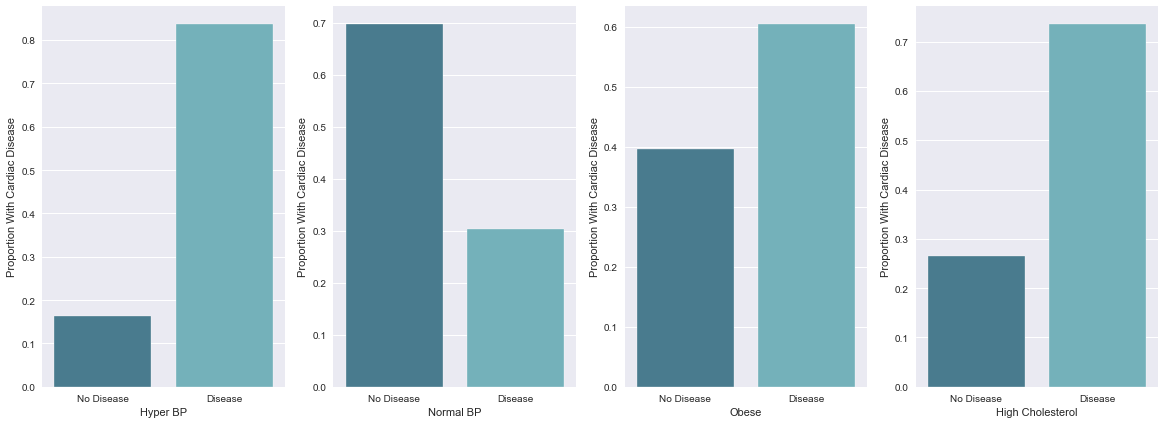

In [24]:
labels = ['Hyper BP', 'Normal BP', 'Obese', 'High Cholesterol']
fig = plt.figure(figsize = (20,7))
for n in range(0,4):
    var = a_list[n]
    ax = fig.add_subplot(1,4,n+1)
    sns.barplot(y = var.sort_index(), x = ['No Disease','Disease'], palette= 'GnBu_d', ax = ax)
    plt.xlabel(labels[n])
    plt.ylabel('Proportion With Cardiac Disease')

plt.savefig('proportions_by_groups.png')